In [2]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../../../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras


In [3]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_0',
    asicVersion = 4
)
root.start()

Simulation mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [4]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 1 day, 21:29:44
GitHash      = 0x563a68027652195474e6a610098a11775111615a
XilinxDnaId  = 0x4002000101604ee71c618205
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.2
BuildServer  = rdsrv408 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 02 Nov 2023 02:16:58 PM PDT
Builder      = ddoering
###################################################


In [5]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
#Init sequence 2 set ro and acq width to 150us
initSequence = 2
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/chargeInjection/../../..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/chargeInjection/../../..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/chargeInjection/../../..//yml/ePixHr10kT_RegisterControl_150us_320MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/chargeInjection/../../..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGit/epix-hr-single-10k/software/notebooks/ASIC_V4/chargeInjection/../../..//yml/ePixHr10kT_PL

In [6]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [7]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3F)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)

Locked lanes: 3f000
Locked lanes: 3f000


In [8]:
def readPixelConfig(ASIC, x, y):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.get() #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

def writedPixelConfig(ASIC, x, y, value):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.set(value) #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

In [9]:
def setPixel (Preamp = 4, Vld1_b = 1, Pixel_CB = 4, Filter_DAC = 38, VRef_DAC = 53):
    ASIC.Preamp.set(Preamp)
    ASIC.Vld1_b.set(Vld1_b)
    ASIC.Pixel_CB.set(Pixel_CB)
    ASIC.Filter_DAC.set(Filter_DAC)
    ASIC.VRef_DAC.set(VRef_DAC)


    print('Preamp', ASIC.Preamp.get())
    print('Vld1_b',ASIC.Vld1_b.get())
    print('Pixel_CB',ASIC.Pixel_CB.get())
    print('Filter_DAC',ASIC.Filter_DAC.get())
    print('VRef_DAC',ASIC.VRef_DAC.get())

In [51]:
def run_asic_test():
    if os.path.isfile(f'{filename}'):
        os.remove(f'{filename}')    

    # Setup and open the file writer
    writer = root.dataWriter._writer
    writer.open(f'{filename}')

    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0) 
    
    ASIC.PulserR.set(True)
    time.sleep(1.0)  
    ASIC.PulserR.set(False)

    #sets TriggerRegisters
    AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(50000) #in steps of 10ns
    root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    #wait for the camera to get thermally stable
    #time.sleep(5.0)    
    root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
    root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
    initialFrameCounter = writer.getFrameCount()
    # Wait for the file write noise data
    while(writer.getFrameCount() < initialFrameCounter + 2000):
        print( f'Number of frames received: {writer.getFrameCount()}' )
        time.sleep(1)

    # stops triggers
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    # Print the status
    DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
    #print( f'Delta Aquisition Counter: {DeltaAcqCount}')
    print( f'Number of frames received: {writer.getFrameCount()}' )

    # Close the file writer
    writer.close()

    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)
    ########################################################################################################################3
    f = open(filename, mode = 'rb')
    imgDesc = []
    for i in range(1):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,8)
        imgDesc2 = currentCam.getDescImaData(allFrames[:,:-8])
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        if i == 1: #skips the first dataset
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    numberOfFrames = allFrames.shape[0]
    print(allFrames.shape)
    ###########################################################################################################################
    return imgDesc

In [11]:
def update_dataset():
    f = open(filename, mode = 'rb')
    imgDesc = []
    print('%x' %(currentCam.bitMask))
    for i in range(1):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,8)
        imgDesc2 = currentCam.getDescImaData(allFrames[:,:-8])
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        if i == 1: #skips the first dataset
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    numberOfFrames = allFrames.shape[0]
    print(allFrames.shape)
    ###########################################################################################################################
    return imgDesc

In [12]:
def chargeInj_print_1(offset = 0):
    plt.figure(1,figsize=(12,8),dpi=150)
    plt.imshow(imgDesc[100], cmap='gray')
    print(imgDesc[100,100,20:40])
    print(imgDesc[100].shape)
    plt.figure(1,figsize=(12,8),dpi=150)
    plt.imshow(imgDesc[100,:,:], cmap='gray')
    ###
    pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
    revd=dict([reversed(i) for i in pixelSettings.items()])
    pixelSettings.update(revd)

    plt.figure(2,figsize=(12,8),dpi=150)
    for i in range(len(pixelListRB)):
        print(i)
        print(imgDesc.shape)
        print(pixelListRB[i][0],pixelListRB[i][1])
        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]], np.std(dataset)))
    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
    plt.legend()
    plt.show()
    ###
    pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
    revd=dict([reversed(i) for i in pixelSettings.items()])
    pixelSettings.update(revd)

    plt.figure(3,figsize=(12,8),dpi=150)
    for i in [0, 2]:
    #range(len(pixelListRB)):
        print(i)
        print(imgDesc.shape)
        print(25,pixelListRB[i][1])
        dataset = imgDesc[180:,25,pixelListRB[i][1]] & 0x7fff
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s' % (25, pixelListRB[i][1], pixelSettings[pixelList[i][2]]))
        plt.ylim([0, 35000])
    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
    plt.legend(loc=1)
    plt.margins(0,0)
    plt.show()
    ##
    fig, axs = plt.subplots(2, 2,figsize=(12,8),dpi=150)
    startingColumn = 30
    for i in range(len(pixelListRB)):
        dataset = imgDesc[172:,pixelListRB[i][0],pixelListRB[i][1]] & 0x7fff
        axs[int(i/2),i%2].plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]]))
        axs[int(i/2),i%2].legend(loc=4)
        axs[int(i/2),i%2].margins(0.05, 0.3)

    axs[1,0].set_xlabel('Pulser DAC [V]')
    axs[1,1].set_xlabel('Pulser DAC [V]')
    axs[0,0].set_ylabel('ADC Units')
    axs[1,0].set_ylabel('ADC Units')
    plt.show()
    ###
    plt.figure(figsize=(12,8),dpi=150)
    for i in range(len(pixelListRB)):
        dataset = (imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]])# - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        plt.hist(dataset.reshape(-1), bins=100, label=f'\nPixel [%d, %d] config: %s noise %d' %(pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelListRB[i][2]], np.std(dataset))) 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    
    


In [13]:
def chargeInj_print_2(initPoint0, initPoint1, initPoint2, traceLength0, traceLength1, traceLength2):
    
    ###
    pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
    revd=dict([reversed(i) for i in pixelSettings.items()])
    pixelSettings.update(revd)

    plt.figure(2,figsize=(10,6),dpi=150)
    for i in range(1):
        print(pixelListRB[i][0],pixelListRB[i][1])
        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        dataset = imgDesc12[initPoint0:initPoint0+traceLength0,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s Comparator Th %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]], 12))
        dataset = imgDesc22[initPoint1:initPoint1+traceLength1,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s Comparator Th %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]], 22))
        dataset = imgDesc32[initPoint2:initPoint2+traceLength2,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s Comparator Th %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]], 32))

    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
    plt.legend()
    plt.show()
    ###
    ###
    pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
    revd=dict([reversed(i) for i in pixelSettings.items()])
    pixelSettings.update(revd)

    plt.figure(2,figsize=(12,8),dpi=150)
    traceLength = 750
    for i in range(1):
        print(pixelListRB[i][0],pixelListRB[i][1])
        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        initPoint = 880
        dataset = imgDesc12[initPoint:initPoint+traceLength,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]], np.std(dataset)))
        
    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
    plt.legend()
    plt.show()
    ###

In [14]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0x3fff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

Camera  ePixHr10kTBatcher  selected.


In [15]:
print(ASIC.CompTH_DAC.get())
print(ASIC.CompEn.get())
print(ASIC.CompEnOn.get())
print(ASIC.Filter_DAC.get())

42
7
True
38


# Original 

In [ ]:
#sets ASIC to point to the external DAC
ASIC.mTest.set(False)
ASIC.trbit.set(True) # high gain
#ASIC.CompTH_DAC.set(42)
ASIC.CompEnOn.set(False) #removes comp en which is needed for charge injection
ASIC.test.set(True)
ASIC.atest.set(True)
print (f'Check trbit (0: medium gain, 1: high gain): %d' % ASIC.trbit.get())
#set pixel configuration
pixelList = [[10, 10, 1],[10, 42, 5],[42, 10, 9],[42, 42, 13]]
pixelOffset = 0
pixelListRB = [[20, 30+pixelOffset, 1],[20, 35+pixelOffset, 5],[20, 40+pixelOffset, 9],[20, 45+pixelOffset, 13]]
for i in range(len(pixelList)):
    print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    print (f'Writing individula pixel')
    writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pixelList[i][2])
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))

for i in range(192):    
    writedPixelConfig(ASIC, 25, i, 1)
    
#code to check successive writes
#row = 111
#col = 180
#for pixelValue in (0, 8, 4, 12):
#    writedPixelConfig(ASIC, row, col, pixelValue)
#    print (f'Pixel setting %d (0: AR, 4: forced switch, 8: fixed low, 12: fixed high), readback: %d' % (pixelValue, readPixelConfig(ASIC, row, col)))


In [ ]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

Preamp = 7#,6,5,4,3,2,1,0]
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58
compTHList = [12,22,32,42,52]

for compTH in compTHList:
    ASIC.CompTH_DAC.set(compTH)
    ASIC.trbit.set(True)
    trbit = ASIC.trbit.get()
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
    ########################################################################################################################
    imgDescH = run_asic_test()
    imgDesc = imgDescH
    ########################################################################################################################
    chargeInj_print_1()
    
    ASIC.trbit.set(False)
    trbit = ASIC.trbit.get()
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
    ########################################################################################################################
    imgDescM = run_asic_test()
    imgDesc = imgDescM
    ########################################################################################################################
    chargeInj_print_1()

In [ ]:
print('%x' %(currentCam.bitMask))
imgDesc = update_dataset()
chargeInj_print_1()

In [ ]:
PreampList=7#,6,5,4,3,2,1,0]
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58
compTHList = [12,22,32,42,52]

compTH = 12
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
imgDesc12 = update_dataset()

compTH = 22
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
imgDesc22 = update_dataset()

compTH = 32
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run1.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
imgDesc32 = update_dataset()



In [ ]:
chargeInj_print_2(550,78,635,300,300,300)

In [ ]:
trbit = True

In [ ]:
PreampList=7#,6,5,4,3,2,1,0]
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58
compTHList = [12,22,32,42,52]

compTH = 12
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
print(filename)
imgDesc12 = update_dataset()

compTH = 22
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
print(filename)
imgDesc22 = update_dataset()

compTH = 32
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
print(filename)
imgDesc32 = update_dataset()



In [ ]:
chargeInj_print_2()

In [ ]:
trbit = False

In [ ]:
PreampList=7#,6,5,4,3,2,1,0]
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58
compTHList = [12,22,32,42,52]

compTH = 12
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
print(filename)
imgDesc12 = update_dataset()

compTH = 22
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
print(filename)
imgDesc22 = update_dataset()

compTH = 32
filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH))
print(filename)
imgDesc32 = update_dataset()


In [ ]:
chargeInj_print_2()

In [ ]:
ASIC.CompTH_DAC.get()

In [ ]:
imgDesc = imgDescH
chargeInj_print_1()
imgDesc = imgDescM
chargeInj_print_1()

# Single Pixel

In [40]:
#sets ASIC to point to the external DAC
ASIC.mTest.set(False)
ASIC.trbit.set(True) # high gain
#ASIC.CompTH_DAC.set(42)
ASIC.CompEnOn.set(False) #removes comp en which is needed for charge injection
ASIC.test.set(True)
ASIC.atest.set(True)
print (f'Check trbit (0: medium gain, 1: high gain): %d' % ASIC.trbit.get())
#set pixel configuration
pixelList = [[10, 10, 1],[10, 42, 5],[42, 10, 9],[42, 42, 13]]
pixelOffset = 0
pixelListRB = [[20, 30+pixelOffset, 1],[20, 35+pixelOffset, 5],[20, 40+pixelOffset, 9],[20, 45+pixelOffset, 13]]
for i in range(len(pixelList)):
    print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    print (f'Writing individula pixel')
    writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pixelList[i][2])
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))

for i in range(192):    
    writedPixelConfig(ASIC, 25, i, 1)
    
#code to check successive writes
#row = 111
#col = 180
#for pixelValue in (0, 8, 4, 12):
#    writedPixelConfig(ASIC, row, col, pixelValue)
#    print (f'Pixel setting %d (0: AR, 4: forced switch, 8: fixed low, 12: fixed high), readback: %d' % (pixelValue, readPixelConfig(ASIC, row, col)))


Check trbit (0: medium gain, 1: high gain): 1

Pixel [10, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [10, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 5

Pixel [42, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9

Pixel [42, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13


In [41]:
def chargeInj_print_3():
    ###
    pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
    revd=dict([reversed(i) for i in pixelSettings.items()])
    pixelSettings.update(revd)

    plt.figure(2,figsize=(6,4),dpi=150)
    for i in range(len(pixelListRB)):
        print(i)
        print(imgDesc.shape)
        print(pixelListRB[i][0],pixelListRB[i][1])
        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pedsList[testIdx]], np.std(dataset)))
    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
    plt.legend()
    plt.show()

Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic2.ClearMatrix
trbit True
Preamp 7
Vld1_b 0
Pixel_CB 7
Filter_DAC 17
VRef_DAC 58

Pixel [10, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13

Pixel [10, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13

Pixel [42, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13

Pixel [42, 42]
Pixel setting (0: AR, 4: forc

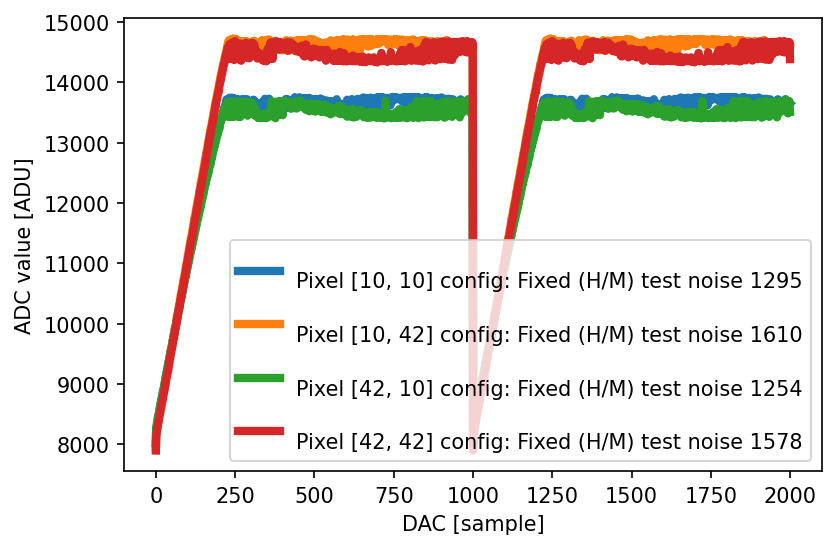

trbit False
Preamp 7
Vld1_b 0
Pixel_CB 7
Filter_DAC 17
VRef_DAC 58

Pixel [10, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13

Pixel [10, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13

Pixel [42, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13

Pixel [42, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Writing individula pixel
Pixel setting (0: AR, 4: forc

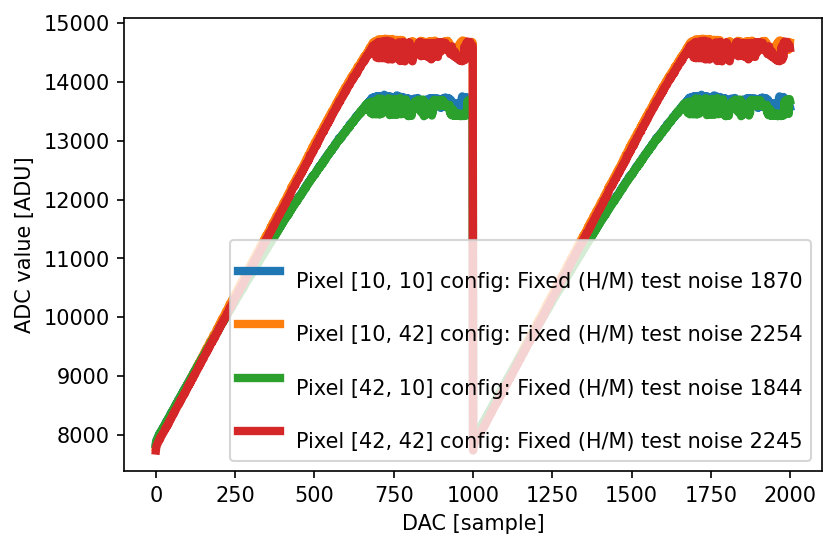

trbit False
Preamp 7
Vld1_b 0
Pixel_CB 7
Filter_DAC 17
VRef_DAC 58

Pixel [10, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9

Pixel [10, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9

Pixel [42, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9

Pixel [42, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13
Writing individula pixel
Pixel setting (0: AR, 4: forced swi

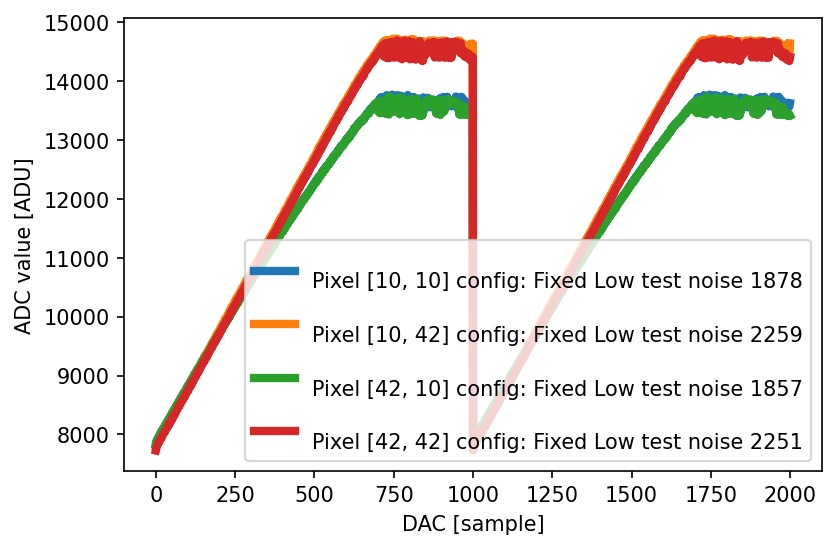

trbit True
Preamp 7
Vld1_b 0
Pixel_CB 7
Filter_DAC 17
VRef_DAC 58

Pixel [10, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [10, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [42, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [42, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 

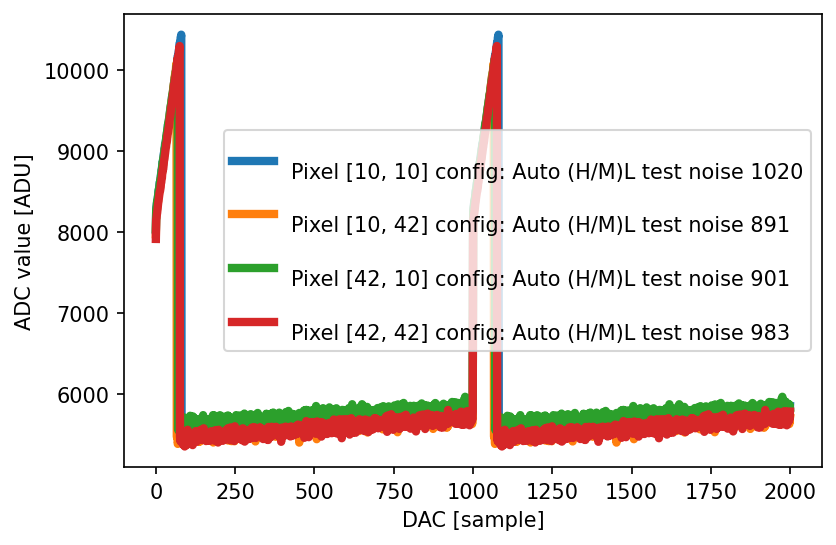

trbit False
Preamp 7
Vld1_b 0
Pixel_CB 7
Filter_DAC 17
VRef_DAC 58

Pixel [10, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [10, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [42, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [42, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1
Writing individula pixel
Pixel setting (0: AR, 4: forced switch,

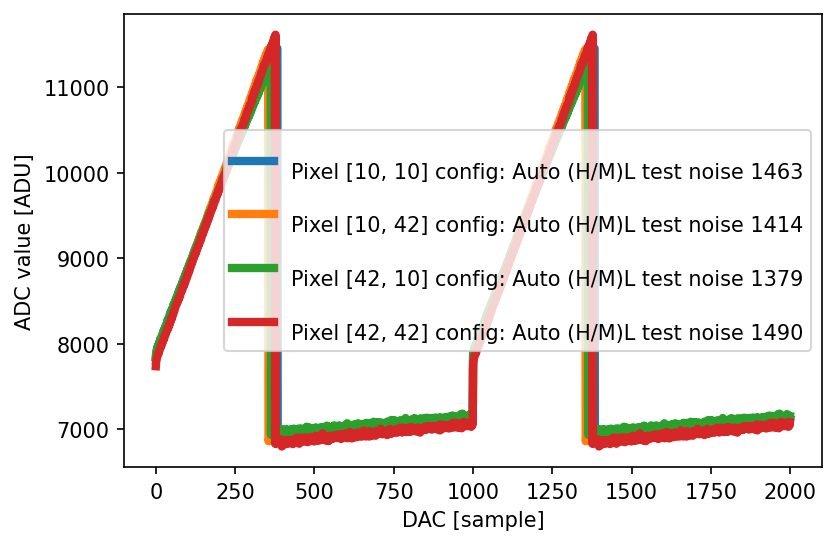

In [52]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

ASIC.ClearMatrix(0)

pixelList = [[10, 10],[10, 42],[42, 10],[42, 42]]
pixelListRB = pixelList
pedsList = [13,13,9,1,1]
trbitList = [True,0,0,True,0]

Preamp = 7#,6,5,4,3,2,1,0]
Vld1_b = 0
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58

compTHList = [12]#,22,32,42,52]

testIdx = 0

for compTH in compTHList:
    ASIC.CompTH_DAC.set(compTH)
    ASIC.trbit.set(trbitList[testIdx])
    trbit = ASIC.trbit.get()
    print("trbit", trbit)
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    for i in range(len(pixelList)):
        print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Writing individula pixel')
        writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pedsList[testIdx])
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_matrixConcit_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH,pedsList[testIdx]))
    if os.path.isfile(f'{filename}'):   
        os.remove(f'{filename}')    
    ########################################################################################################################
    imgDescFH = run_asic_test()
    imgDesc = imgDescFH
    ########################################################################################################################
    chargeInj_print_3()
    ########################################################################################################################
    ####
    ####
    ####
    ########################################################################################################################
    testIdx = 1
    ASIC.CompTH_DAC.set(compTH)
    ASIC.trbit.set(trbitList[testIdx])
    trbit = ASIC.trbit.get()
    print("trbit", trbit)
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    for i in range(len(pixelList)):
        print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Writing individula pixel')
        writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pedsList[testIdx])
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_matrixConcit_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH,pedsList[testIdx]))
    if os.path.isfile(f'{filename}'):   
        os.remove(f'{filename}')    
    ########################################################################################################################
    imgDescFM = run_asic_test()
    imgDesc = imgDescFM
    ########################################################################################################################
    chargeInj_print_3()
    ########################################################################################################################
    ########################################################################################################################
    ####
    ####
    ####
    ########################################################################################################################
    testIdx = 2
    ASIC.CompTH_DAC.set(compTH)
    ASIC.trbit.set(trbitList[testIdx])
    trbit = ASIC.trbit.get()
    print("trbit", trbit)
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    for i in range(len(pixelList)):
        print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Writing individula pixel')
        writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pedsList[testIdx])
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_matrixConcit_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH,pedsList[testIdx]))
    if os.path.isfile(f'{filename}'):   
        os.remove(f'{filename}')    
    ########################################################################################################################
    imgDescFL = run_asic_test()
    imgDesc = imgDescFL
    ########################################################################################################################
    chargeInj_print_3()
    ########################################################################################################################
    ########################################################################################################################
    ####
    ####
    ####
    ########################################################################################################################
    testIdx = 3
    ASIC.CompTH_DAC.set(compTH)
    ASIC.trbit.set(trbitList[testIdx])
    trbit = ASIC.trbit.get()
    print("trbit", trbit)
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    for i in range(len(pixelList)):
        print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Writing individula pixel')
        writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pedsList[testIdx])
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_matrixConcit_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH,pedsList[testIdx]))
    if os.path.isfile(f'{filename}'):   
        os.remove(f'{filename}')    
    ########################################################################################################################
    imgDescAHL = run_asic_test()
    imgDesc = imgDescAHL
    ########################################################################################################################
    chargeInj_print_3()
    ########################################################################################################################
    ########################################################################################################################
    ####
    ####
    ####
    ########################################################################################################################
    testIdx = 4
    ASIC.CompTH_DAC.set(compTH)
    ASIC.trbit.set(trbitList[testIdx])
    trbit = ASIC.trbit.get()
    print("trbit", trbit)
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    
    for i in range(len(pixelList)):
        print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Writing individula pixel')
        writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pedsList[testIdx])
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
        print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V4_ASIC2_SB/ePixHR10kTLCLSIITiming_ASICV4_ASIC2_chargeInj_atest_highToLow_320MHz_initSequence_%d_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_trbit_%d_compTH_%d_matrixConcit_%d_run2.dat' % (initSequence, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, trbit, compTH,pedsList[testIdx]))
    if os.path.isfile(f'{filename}'):   
        os.remove(f'{filename}')    
    ########################################################################################################################
    imgDescAML = run_asic_test()
    imgDesc = imgDescAML
    ########################################################################################################################
    chargeInj_print_3()
    ########################################################################################################################
    

In [33]:
def chargeInj_print_4():
    ###
    pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
    revd=dict([reversed(i) for i in pixelSettings.items()])
    pixelSettings.update(revd)

    plt.figure(2,figsize=(6,4),dpi=150)
    for i in range(len(pixelListRB)):
        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        dataset = imgDescFH[:,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pedsList[testIdx]], np.std(dataset)))
    for i in range(len(pixelListRB)):
        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        dataset = imgDescFM[:,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pedsList[testIdx]], np.std(dataset))) 
    for i in range(len(pixelListRB)):
        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        dataset = imgDescFL[:,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pedsList[testIdx]], np.std(dataset)))
    for i in range(len(pixelListRB)):
        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        dataset = imgDescAHL[:,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pedsList[testIdx]], np.std(dataset)))
    for i in range(len(pixelListRB)):

        #dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
        dataset = imgDescAML[:,pixelListRB[i][0],pixelListRB[i][1]]
        plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pedsList[testIdx]], np.std(dataset)))
    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
 #   plt.legend()
    plt.show()

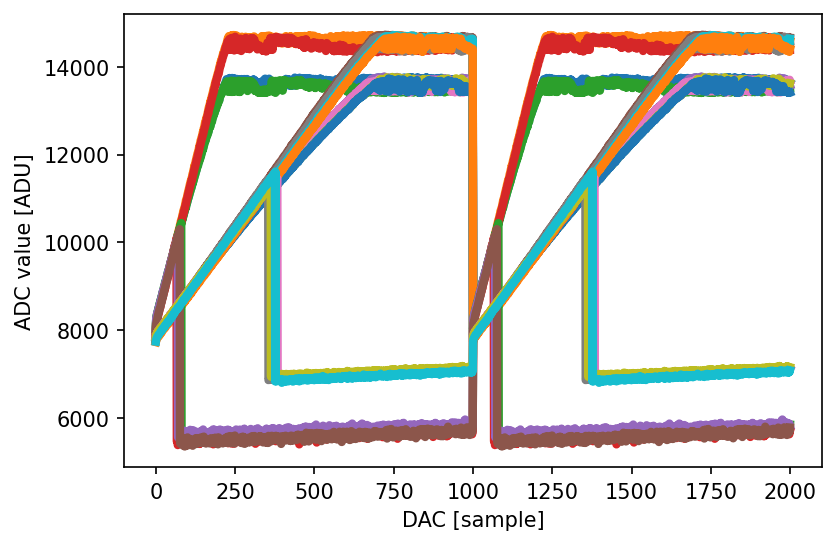

In [53]:
chargeInj_print_4()

# Remove previous dataset
#if os.path.isfile(f'{top_level}/test.dat'):
#    os.remove(f'{top_level}/test.dat')    
filename = '/u1/ddoering/ePixHR10kTLCLSIITiming_ASICV3_atest_320MHz_AHL_run2.dat'

if os.path.isfile(f'{filename}'):
    os.remove(f'{filename}')    
    
# Setup and open the file writer
writer = root.dataWriter._writer
writer.open(f'{filename}')

# Wait for the file write to open the file
while( writer.isOpen() is False):
    time.sleep(0.1)

# Wait a little bit for the file to open up
time.sleep(1.0)    
    
#sets TriggerRegisters
AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
print("Aquisition Counter " + str(AcqCount))
root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(50000) #in steps of 10ns
root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
#wait for the camera to get thermally stable
time.sleep(5.0)    
root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
initialFrameCounter = writer.getFrameCount()
# Wait for the file write noise data
while(writer.getFrameCount() < initialFrameCounter + 2000):
    print( f'Number of frames received: {writer.getFrameCount()}' )
    time.sleep(1)

# stops triggers
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

# Print the status
DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
#print( f'Delta Aquisition Counter: {DeltaAcqCount}')
print( f'Number of frames received: {writer.getFrameCount()}' )
        
# Close the file writer
writer.close()

# Wait for the file write to close the file
while( writer.isOpen() is True):
    time.sleep(0.1)

from importlib import reload
reload(cameras)

MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask
currentCam.MAX_NUMBER_OF_FRAMES_PER_BATCH  = MAX_NUMBER_OF_FRAMES_PER_BATCH


f = open(filename, mode = 'rb')
imgDesc = []
for i in range(2):
    print("Starting to get data set %d" % (i))
    allFrames = currentCam.getData(f,8)
    imgDesc2 = np.flip(currentCam.getDescImaData(allFrames), 0)
    if i == 0:
        headers = allFrames[:,0:6]
        imgDesc = imgDesc2
    else:
        headers = np.concatenate((headers, allFrames[:,0:6]),0)
        imgDesc = np.concatenate((imgDesc, imgDesc2),0)
    if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
        break


numberOfFrames = allFrames.shape[0]
print(allFrames.shape)

plt.figure(1,figsize=(12,8),dpi=150)
plt.imshow(imgDesc[100], cmap='gray')
print(imgDesc[100,100,20:40])

print(imgDesc[100].shape)
plt.figure(1,figsize=(12,8),dpi=150)
plt.imshow(imgDesc[100,0:30,192:252], cmap='gray')


pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
revd=dict([reversed(i) for i in pixelSettings.items()])
pixelSettings.update(revd)

plt.figure(1,figsize=(12,8),dpi=150)
for i in range(len(pixelListRB)):
    print(i)
    print(imgDesc.shape)
    print(pixelListRB[i][0],pixelListRB[i][1])
    dataset = imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]] - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
    plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s noise %d' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]], np.std(dataset)))
plt.xlabel('DAC [sample]')
plt.ylabel('ADC value [ADU]')
plt.legend()
plt.show()

pixelSettings = dict([('Auto (H/M)L', 0), ('Forced Switched', 4), ('Fixed Low', 8), ('Fixed (H/M)', 12), ('Auto (H/M)L test', 1), ('Forced Switched test', 5), ('Fixed Low test', 9), ('Fixed (H/M) test', 13)])
revd=dict([reversed(i) for i in pixelSettings.items()])
pixelSettings.update(revd)

plt.figure(1,figsize=(12,8),dpi=150)
for i in [0, 2]:
#range(len(pixelListRB)):
    print(i)
    print(imgDesc.shape)
    print(25,pixelListRB[i][1])
    dataset = imgDesc[180:,25,pixelListRB[i][1]] & 0x7fff
    plt.plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s' % (25, pixelListRB[i][1], pixelSettings[pixelList[i][2]]))
    plt.ylim([0, 35000])
plt.xlabel('DAC [sample]')
plt.ylabel('ADC value [ADU]')
plt.legend(loc=1)
plt.margins(0,0)
plt.show()

fig, axs = plt.subplots(2, 2,figsize=(12,8),dpi=150)
startingColumn = 30
for i in range(len(pixelListRB)):
    dataset = imgDesc[172:,pixelListRB[i][0],pixelListRB[i][1]] & 0x7fff
    axs[int(i/2),i%2].plot(dataset, linewidth=4,label=f'\nPixel [%d, %d] config: %s' % (pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelList[i][2]]))
    axs[int(i/2),i%2].legend(loc=4)
    axs[int(i/2),i%2].margins(0.05, 0.3)
    
axs[1,0].set_xlabel('Pulser DAC [V]')
axs[1,1].set_xlabel('Pulser DAC [V]')
axs[0,0].set_ylabel('ADC Units')
axs[1,0].set_ylabel('ADC Units')

plt.show()

In [ ]:
for i in range(len(pixelListRB)):
    print(i)
    print(imgDesc.shape)
    print(pixelListRB[i][0],pixelListRB[i][1])
    print(imgDesc[:20,pixelListRB[i][0],pixelListRB[i][1]])

plt.figure(1,figsize=(12,8),dpi=150)
for i in range(len(pixelListRB)):
    dataset = (imgDesc[:,pixelListRB[i][0],pixelListRB[i][1]])# - float(np.mean(imgDesc[0:1000,pixelListRB[i][0],pixelListRB[i][1]]))
    plt.hist(dataset.reshape(-1), bins=100, label=f'\nPixel [%d, %d] config: %s noise %d' %(pixelListRB[i][0], pixelListRB[i][1], pixelSettings[pixelListRB[i][2]], np.std(dataset))) 
plt.yscale('log')
plt.title("histogram") 
plt.legend()
plt.show()